In [2]:
pip install xgboost

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 8.1 MB/s eta 0:00:00m eta 0:00:010:01:01
  DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
plt.style.use("./deeplearning.mplstyle")

In [13]:
RANDOM_STATE = 55

In [5]:
df = pd.read_csv("./heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
cat_variables = ['Sex',
'ChestPainType',
'RestingECG',
'ExerciseAngina',
'ST_Slope'
]

In [8]:
help(pd.get_dummies)

Help on function get_dummies in module pandas.core.reshape.encoding:

get_dummies(data, prefix=None, prefix_sep: 'str | Iterable[str] | dict[str, str]' = '_', dummy_na: 'bool' = False, columns=None, sparse: 'bool' = False, drop_first: 'bool' = False, dtype: 'NpDtype | None' = None) -> 'DataFrame'
    Convert categorical variable into dummy/indicator variables.
    
    Each variable is converted in as many 0/1 variables as there are different
    values. Columns in the output are each named after a value; if the input is
    a DataFrame, the name of the original variable is prepended to the value.
    
    Parameters
    ----------
    data : array-like, Series, or DataFrame
        Data of which to get dummy indicators.
    prefix : str, list of str, or dict of str, default None
        String to append DataFrame column names.
        Pass a list with length equal to the number of columns
        when calling get_dummies on a DataFrame. Alternatively, `prefix`
        can be a diction

In [9]:
# This will replace the columns with the one-hot encoded ones and keep the columns outside 'columns' argument as it is.
df = pd.get_dummies(data = df,
                         prefix = cat_variables,
                         columns = cat_variables)
df.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,False,True,False,...,False,False,False,True,False,True,False,False,False,True
1,49,160,180,0,156,1.0,1,True,False,False,...,True,False,False,True,False,True,False,False,True,False
2,37,130,283,0,98,0.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,True
3,48,138,214,0,108,1.5,1,True,False,True,...,False,False,False,True,False,False,True,False,True,False
4,54,150,195,0,122,0.0,0,False,True,False,...,True,False,False,True,False,True,False,False,False,True


In [10]:
features = [x for x in df.columns if x not in 'HeartDisease'] ## Removing our target variable

In [11]:
print(len(features))

20


In [14]:
X_train, X_val, y_train, y_val = train_test_split(df[features], df['HeartDisease'], train_size = 0.8, random_state = RANDOM_STATE)

In [15]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 734
validation samples: 184
target proportion: 0.5518


# 4. Building the Models

## 4.1 Decision Tree

In this section, let's work with the Decision Tree we previously learned, but now using the [Scikit-learn implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html). 

There are several hyperparameters in the Decision Tree object from Scikit-learn. We will use only some of them and also we will not perform feature selection nor hyperparameter tuning in this lab (but you are encouraged to do so and compare the results 😄 )

The hyperparameters we will use and investigate here are:

 - min_samples_split: The minimum number of samples required to split an internal node. 
   - Choosing a higher min_samples_split can reduce the number of splits and may help to reduce overfitting.
 - max_depth: The maximum depth of the tree. 
   - Choosing a lower max_depth can reduce the number of splits and may help to reduce overfitting.

In [16]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.

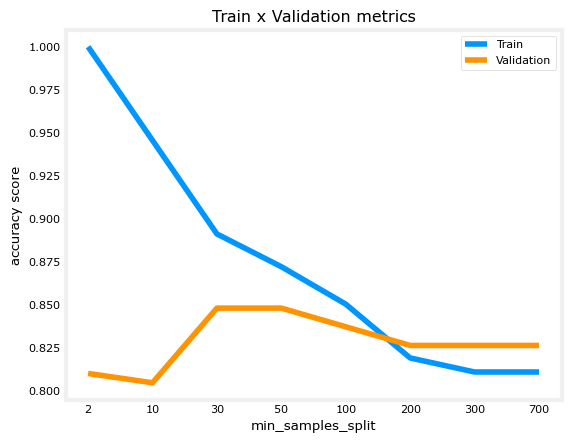

In [17]:
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    model = DecisionTreeClassifier(min_samples_split=min_samples_split, random_state=RANDOM_STATE).fit(X_train, y_train)

    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title("Train x Validation metrics")
plt.xlabel('min_samples_split')
plt.ylabel('accuracy score')
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

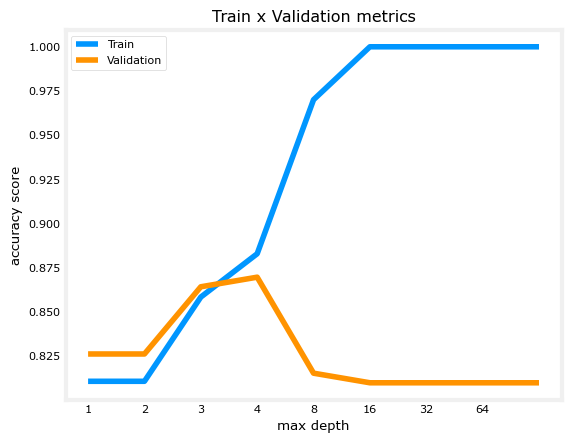

In [18]:
accuracy_list_train = []
accuracy_list_val = []

for max_depth in max_depth_list:
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=RANDOM_STATE).fit(X_train, y_train)

    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max depth')
plt.ylabel('accuracy score')
plt.xticks(ticks=range(len(max_depth_list)), labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

In [19]:
decision_tree_model = DecisionTreeClassifier(min_samples_split = 50,
                                             max_depth = 3,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [20]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.8583
Metrics validation:
	Accuracy score: 0.8641


## 4.2 Random Forest

Now let's try the Random Forest algorithm also, using the Scikit-learn implementation. 
- All of the hyperparameters found in the decision tree model will also exist in this algorithm, since a random forest is an ensemble of many Decision Trees.
- One additional hyperparameter for Random Forest is called `n_estimators` which is the number of Decision Trees that make up the Random Forest. 

Remember that for a Random Forest, we randomly choose a subset of the features AND randomly choose a subset of the training examples to train each individual tree.
- Following the lectures, if $n$ is the number of features, we will randomly select $\sqrt{n}$ of these features to train each individual tree. 
- Note that you can modify this by setting the `max_features` parameter.

You can also speed up your training jobs with another parameter, `n_jobs`. 
- Since the fitting of each tree is independent of each other, it is possible fit more than one tree in parallel. 
- So setting `n_jobs` higher will increase how many CPU cores it will use. Note that the numbers very close to the maximum cores of your CPU may impact on the overall performance of your PC and even lead to freezes. 
- Changing this parameter does not impact on the final result but can reduce the training time.

We will run the same script again, but with another parameter, `n_estimators`, where we will choose between 10, 50, and 100. The default is 100.

In [21]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700]  ## If the number is an integer, then it is the actual quantity of samples,
                                             ## If it is a float, then it is the percentage of the dataset
max_depth_list = [2, 4, 8, 16, 32, 64, None]
n_estimators_list = [10,50,100,500]

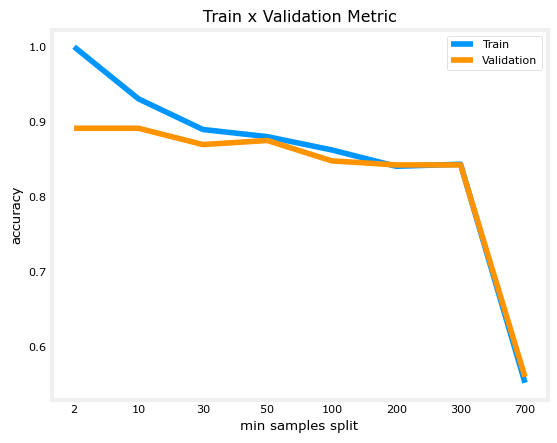

In [22]:
accuracy_list_train = []
accuracy_list_val = []

for min_samples_split in min_samples_split_list:
    model = RandomForestClassifier(min_samples_split=min_samples_split, random_state=RANDOM_STATE).fit(X_train, y_train)

    predictions_train = model.predict(X_train)
    predictions_val = model.predict(X_val)
    accuracy_train = accuracy_score(predictions_train, y_train)
    accuracy_val = accuracy_score(predictions_val, y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title("Train x Validation Metric")
plt.xlabel("min samples split")
plt.ylabel('accuracy')
plt.xticks(ticks=range(len(min_samples_split_list)), labels=min_samples_split_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train', 'Validation'])

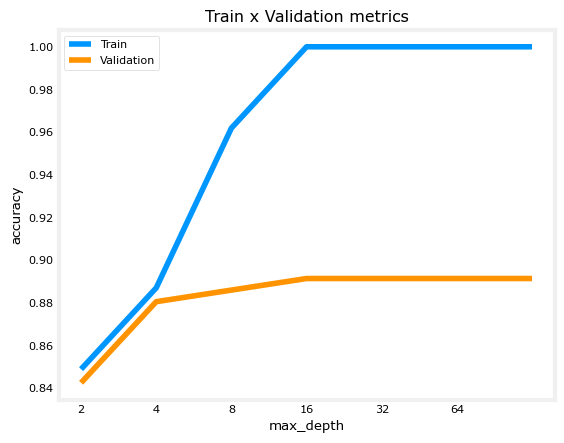

In [23]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

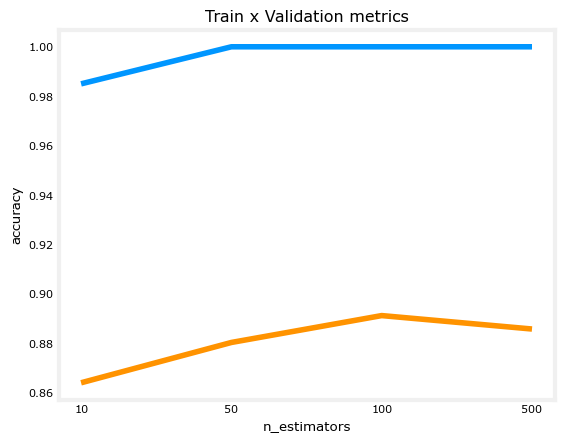

In [24]:
accuracy_list_train = []
accuracy_list_val = []
for n_estimators in n_estimators_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(n_estimators = n_estimators,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(n_estimators_list )),labels=n_estimators_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)

In [25]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 16, 
                                             min_samples_split = 10).fit(X_train,y_train)

In [26]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9387
Metrics test:
	Accuracy score: 0.8913


## 4.3 XGBoost

Next is the Gradient Boosting model, called XGBoost. The boosting methods train several trees, but instead of them being uncorrelated to each other, now the trees are fit one after the other in order to minimize the error. 

The model has the same parameters as a decision tree, plus the learning rate.
- The learning rate is the size of the step on the Gradient Descent method that the XGBoost uses internally to minimize the error on each train step.

One interesting thing about the XGBoost is that during fitting, it can take in an evaluation dataset of the form `(X_val,y_val)`.
- On each iteration, it measures the cost (or evaluation metric) on the evaluation datasets.
- Once the cost (or metric) stops decreasing for a number of rounds (called early_stopping_rounds), the training will stop. 
- More iterations lead to more estimators, and more estimators can result in overfitting.  
- By stopping once the validation metric no longer improves, we can limit the number of estimators created, and reduce overfitting.

First, let's define a subset of our training set (we should not use the test set here).

In [28]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval

In [29]:
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [31]:
xgb_model = XGBClassifier(n_estimators=500, learning_rate=0.1, verbosity=1,random_state=RANDOM_STATE, early_stopping_rounds=10)
xgb_model.fit(X_train_fit, y_train_fit, eval_set=[(X_train_eval, y_train_eval)])

[0]	validation_0-logloss:0.63302
[1]	validation_0-logloss:0.59554
[2]	validation_0-logloss:0.56614
[3]	validation_0-logloss:0.54187
[4]	validation_0-logloss:0.52349
[5]	validation_0-logloss:0.50611
[6]	validation_0-logloss:0.49373
[7]	validation_0-logloss:0.48366
[8]	validation_0-logloss:0.47323
[9]	validation_0-logloss:0.46538
[10]	validation_0-logloss:0.46000
[11]	validation_0-logloss:0.45621
[12]	validation_0-logloss:0.45483
[13]	validation_0-logloss:0.44975
[14]	validation_0-logloss:0.44495
[15]	validation_0-logloss:0.44073
[16]	validation_0-logloss:0.44078
[17]	validation_0-logloss:0.43936
[18]	validation_0-logloss:0.44206
[19]	validation_0-logloss:0.44536
[20]	validation_0-logloss:0.44322
[21]	validation_0-logloss:0.44310
[22]	validation_0-logloss:0.44419
[23]	validation_0-logloss:0.44797
[24]	validation_0-logloss:0.44843
[25]	validation_0-logloss:0.45337
[26]	validation_0-logloss:0.45206


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=55, ...)

In [32]:
xgb_model.best_iteration

17

In [33]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9319
Metrics test:
	Accuracy score: 0.8533
